In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
pwd = 'work'

In [9]:
pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 3.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.9 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


### **Part 1:** Data Manipulation and EDA

**Objective:** Explore data, identify trends, and generate initial insights.

**Task:**

A.) Data Cleaning:

* Handle any missing values in the dataset by choosing appropriate strategies
* Identify and remove any duplicates that may be present in the data
* Detect and address any outliers that could skew your analysis

In [127]:
# Load the data from the files
pricing_data = pd.read_csv(pwd + '/data/Test Data - Test Property Pricing.csv', header=1)
booking_data = pd.read_csv(pwd + '/data/Test Data - Historical Booking data.csv')
competitor_data = pd.read_csv(pwd + '/data/Test Data - Market Data.csv')

# Rename the columns of the data for reorganization
pricing_data.columns = ['Accommodation name', 'Property ID', 
                        'Date 2022', 'Day 2022', 'Price per night without tax 2022', 
                        'Date 2023', 'Day 2023', 'Price per night without tax 2023', 
                        'Date 2024', 'Day 2024', 'Price per night without tax 2024',
                        'Date 2025', 'Day 2025', 'Price per night without tax 2025']

# Organize the pricing data into a more usable format
data = pd.DataFrame()
years = ['2022', '2023', '2024', '2025']
for year in years:
    temp = pricing_data[['Accommodation name', 'Property ID', 'Date ' + year, 'Day ' + year, 'Price per night without tax ' + year]].copy()
    temp.columns = ['Accommodation name', 'Property ID', 'Date', 'Day', 'Price per night without tax']
    temp['Year'] = year
    data = pd.concat([data, temp], ignore_index=True)
pricing_data = data

# Fill the accommodation name and property ID for the missing values the date 31/12/2024 with the data un the previous date
pricing_data.loc[pricing_data['Date'] == '31/12/2024', 'Accommodation name'] = pricing_data.loc[pricing_data['Date'] == '30/12/2024', 'Accommodation name'].values
pricing_data.loc[pricing_data['Date'] == '31/12/2024', 'Property ID'] = pricing_data.loc[pricing_data['Date'] == '30/12/2024', 'Property ID'].values

# Chek for this specific case
print(f'Data 31-12-2024 {pricing_data[pricing_data["Date"] == "31/12/2024"]}')

Data 31-12-2024      Accommodation name  Property ID        Date      Day  \
1097        Test home 1     123456.0  31/12/2024  Tuesday   

      Price per night without tax  Year  
1097                        534.0  2024  


10:46:23 - cmdstanpy - INFO - Chain [1] start processing
10:46:23 - cmdstanpy - INFO - Chain [1] done processing


Accommodation name               3
Property ID                      3
Date                             3
Day                              3
Price per night without tax    125
Year                             0
dtype: int64
--- Missing values:      Accommodation name  Property ID Date  Day  Price per night without tax  \
365                 NaN          NaN  NaN  NaN                          NaN   
731                 NaN          NaN  NaN  NaN                          NaN   
1463                NaN          NaN  NaN  NaN                          NaN   

      Year  
365   2022  
731   2023  
1463  2025  
--- Interpolated values:      Accommodation name  Property ID       Date        Day  \
365         Test home 1     123456.0 2022-12-31   Saturday   
731         Test home 1     123456.0 2023-12-31     Sunday   
1463        Test home 1     123456.0 2025-12-31  Wednesday   

      Price per night without tax  Year  
365                         307.5  2022  
731                         33

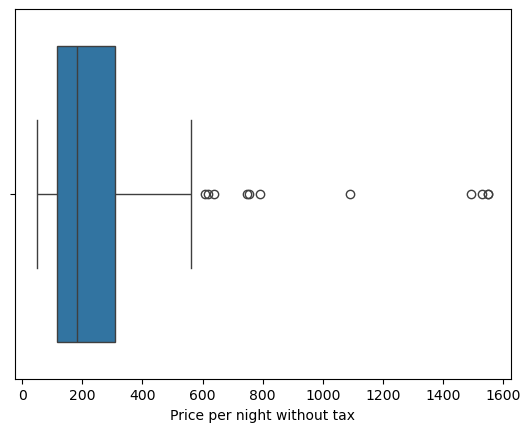

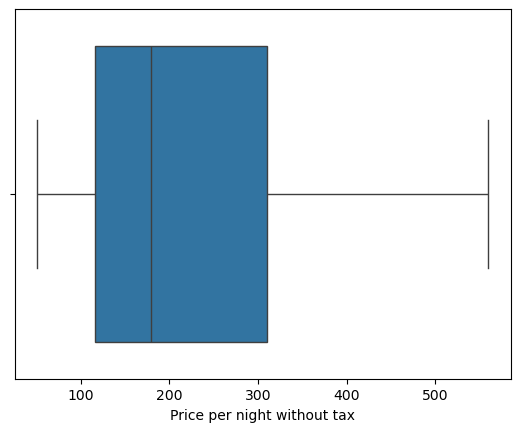

In [128]:
# Pricing data

# Handle missing values

print(pricing_data.isnull().sum())
missing_values_pricing = pricing_data[pricing_data[['Accommodation name', 'Property ID', 'Date', 'Day']].isnull().any(axis=1)]
print(f'--- Missing values: {missing_values_pricing}')
# Fill the missing values in the accommodation name and property ID with the data from the previous date
pricing_data['Accommodation name'] = pricing_data['Accommodation name'].ffill()
pricing_data['Property ID'] = pricing_data['Property ID'].ffill()
pricing_data['Date'] = pricing_data['Date'].ffill()
pricing_data['Date'] = pd.to_datetime(pricing_data['Date'], format='%d/%m/%Y')
# Generate the day of the week from the date
pricing_data['Day'] = pd.to_datetime(pricing_data['Date']).dt.day_name()
# Interpolate just this missing values in the price column
missing_values_pricing_index = missing_values_pricing.index
pricing_data = pricing_data.sort_values(by='Date')
pricing_data.loc[missing_values_pricing_index, 'Price per night without tax'] = pricing_data['Price per night without tax'].interpolate()
# Check for interpolated values
print(f'--- Interpolated values: {pricing_data.loc[missing_values_pricing_index]}')

# Convert types to the correct format
pricing_data['Date'] = pd.to_datetime(pricing_data['Date'], format='%d/%m/%Y')
pricing_data['Day'] = pricing_data['Date'].dt.day_of_week
pricing_data['Year'] = pricing_data['Year'].astype(int)
pricing_data['Property ID'] = pricing_data['Property ID'].astype(int)
pricing_data['Accommodation name'] = pricing_data['Accommodation name'].astype(str)

missing_values_pricing = pricing_data[pricing_data[['Price per night without tax']].isnull().any(axis=1)]
missing_values_pricing_count = missing_values_pricing.shape[0]
missing_values_pricing_index = missing_values_pricing.index
print(f'--- Missing values price: {missing_values_pricing}')

# Fill the missing values in the price with temporal series prediction because the null values are at the end of the series and the price have a seasonal pattern

df = pricing_data[['Date', 'Price per night without tax']].copy()
df.columns = ['ds', 'y']
model = Prophet()
model.fit(df)
future_dates = model.make_future_dataframe(periods=missing_values_pricing_count)
forecast = model.predict(future_dates)
pricing_data.loc[pricing_data['Price per night without tax'].isna(), 'Price per night without tax'] = forecast['yhat']

# Check for interpolated values
print(f'--- Interpolated values: {pricing_data.loc[missing_values_pricing_index]}')

# Identify and remove duplicates
duplicates = pricing_data[pricing_data.duplicated()]
print(f'--- Duplicates: {duplicates}')

# outliers
sns.boxplot(x=pricing_data['Price per night without tax'])
plt.show()

# Remove outliers
Q1 = pricing_data['Price per night without tax'].quantile(0.25)
Q3 = pricing_data['Price per night without tax'].quantile(0.75)
IQR = Q3 - Q1
pricing_data = pricing_data[~((pricing_data['Price per night without tax'] < (Q1 - 1.5 * IQR)) | (pricing_data['Price per night without tax'] > (Q3 + 1.5 * IQR)))]
sns.boxplot(x=pricing_data['Price per night without tax'])
plt.show()

--- Missing values: Booking number                 0
Booking Date                   0
Status                         0
Check-in date                  0
Check-out date                 0
nights                         0
Price per night without tax    0
Rent with VAT on top           0
Rent without VAT               0
Extras with VAT on top         0
Extras without VAT             0
Booking total with tax         0
Booking total without tax      0
Total tax                      0
Paid                           0
Adults                         0
Children                       0
Babies                         0
Accommodation name             0
Property ID                    0
Building                       0
City                           0
Portal / Agent                 0
Website of origin              0
dtype: int64


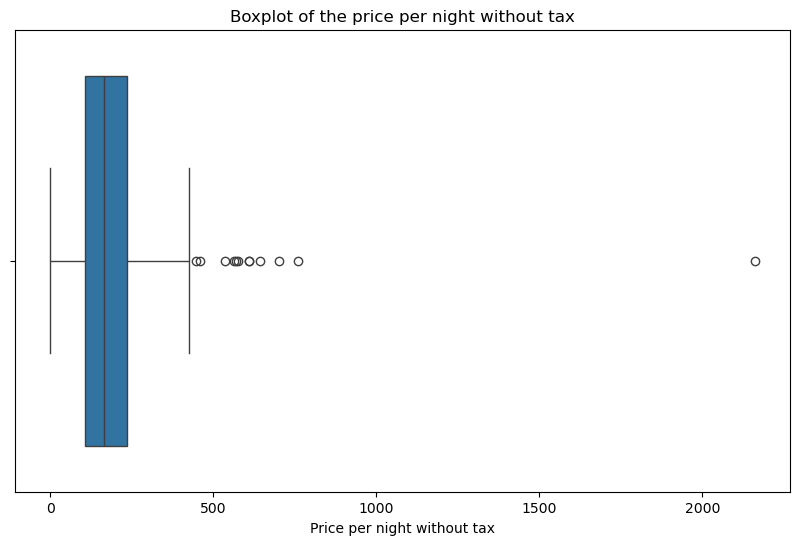

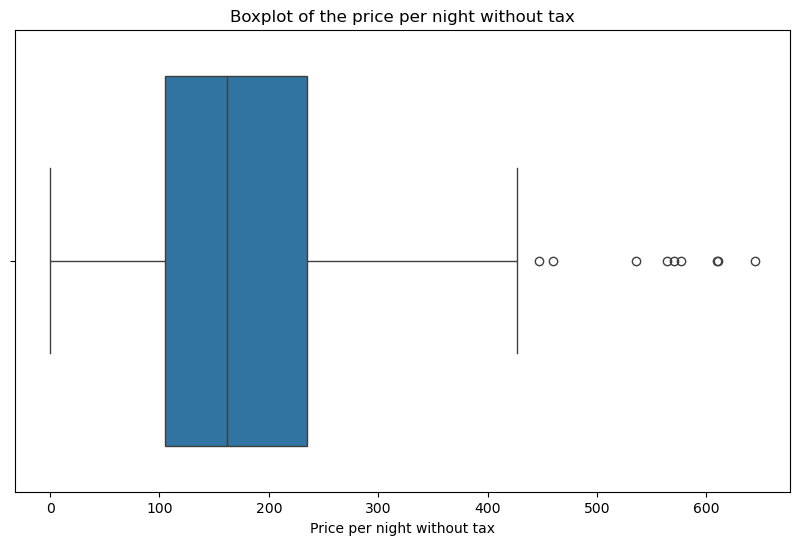

Booking number                         object
Booking Date                           object
Status                                 object
Check-in date                  datetime64[ns]
Check-out date                 datetime64[ns]
nights                                float64
Price per night without tax           float64
Rent with VAT on top                  float64
Rent without VAT                      float64
Extras with VAT on top                float64
Extras without VAT                    float64
Booking total with tax                float64
Booking total without tax             float64
Total tax                             float64
Paid                                  float64
Adults                                  int64
Children                                int64
Babies                                  int64
Accommodation name                     object
Property ID                             int64
Building                               object
City                              

In [129]:
# Booking data

# # Handle missing values
# print(booking_data.isnull().sum())

# Handle missing values in the nights column
# Convwert the date columns to datetime
booking_data['Check-in date'] = pd.to_datetime(booking_data['Check-in date'], format='%d/%m/%Y')
booking_data['Check-out date'] = pd.to_datetime(booking_data['Check-out date'], format='%d/%m/%Y')
# Calculate the number of nights from the check-in and check-out dates
missing_nights_booking = booking_data['nights'].isna()
booking_data.loc[missing_nights_booking, 'nights'] = (booking_data['Check-out date'] - booking_data['Check-in date']).dt.days

# Handle missing values in the price per night column
missing_price_booking = booking_data['Price per night without tax'].isna()
# Calculate the price per night for the missing values
booking_data.loc[missing_price_booking, 'Price per night without tax'] = (booking_data.loc[missing_price_booking, 'Rent without VAT'] / booking_data.loc[missing_price_booking, 'nights']).round(2)

# Handle missing values in the website column
# Where the portal/agent is Muchosol, the website of origin is www.muchosol.es
booking_data.loc[booking_data['Portal / Agent'] == 'Muchosol', 'Website of origin'] = 'www.muchosol.es'
booking_data.loc[booking_data['Portal / Agent'] == 'booking.com', 'Website of origin'] = 'www.booking.com'
booking_data.loc[booking_data['Portal / Agent'] == 'Olalahomes.com', 'Website of origin'] = 'www.olalahomes.com'
# Fill the other missing values in the website column as they are booking directly 
booking_data['Website of origin'] = booking_data['Website of origin'].fillna('Direct')

# Check for missing values
print(f'--- Missing values: {booking_data.isnull().sum()}')

# Outliers

# Check for outliers in the booking data
plt.figure(figsize=(10, 6))
sns.boxplot(x=booking_data['Price per night without tax'])
plt.title('Boxplot of the price per night without tax')
plt.show()


# Remove outliers in the booking data
# Calculate the z-score for the price per night without tax
z = (booking_data['Price per night without tax'] - booking_data['Price per night without tax'].mean()) / booking_data['Price per night without tax'].std()
# Remove the rows with z-score greater than 3
booking_data = booking_data[z < 3]

# Check for outliers in the booking data
plt.figure(figsize=(10, 6))
sns.boxplot(x=booking_data['Price per night without tax'])
plt.title('Boxplot of the price per night without tax')
plt.show()


# Convert types to the correct format
print(booking_data.dtypes)
booking_data['Booking Date'] = pd.to_datetime(booking_data['Booking Date'], format='%d/%m/%Y')
booking_data['Accommodation name'] = booking_data['Accommodation name'].astype(str)
booking_data['Building'] = booking_data['Building'].astype(str)
booking_data['City'] = booking_data['City'].astype(str)
booking_data['Portal / Agent'] = booking_data['Portal / Agent'].astype(str)
booking_data['Website of origin'] = booking_data['Website of origin'].astype(str)

# Identify and remove duplicates
duplicates = booking_data[booking_data.duplicated()]
print(f'--- Duplicates: {duplicates}')
# There are no relevant duplicates in the booking data so we can continue

# Anotation: The Rent without VAT and the Rent with VAT are the same


Date              0
Day               0
Competitor Avg    0
dtype: int64
Date              object
Day               object
Competitor Avg     int64
dtype: object
--- Duplicates: Empty DataFrame
Columns: [Date, Day, Competitor Avg]
Index: []


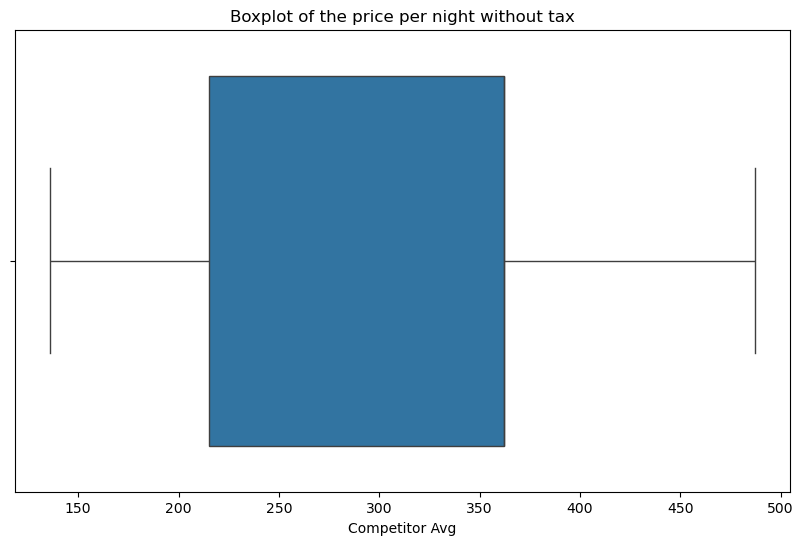

In [130]:
# Competitor data

# Handle missing values
print(competitor_data.isnull().sum())

# Convert types to the correct format
print(competitor_data.dtypes)
competitor_data['Date'] = pd.to_datetime(competitor_data['Date'], format='%d/%m/%Y')
competitor_data['Day'] = competitor_data['Date'].dt.day_of_week

# Identify and remove duplicates
duplicates = competitor_data[competitor_data.duplicated()]
print(f'--- Duplicates: {duplicates}')
# There are no duplicates in the competitor data so we can continue

# Outliers

# Check for outliers in the competitor data
plt.figure(figsize=(10, 6))
sns.boxplot(x=competitor_data['Competitor Avg'])
plt.title('Boxplot of the price per night without tax')
plt.show()

# Don't remove outliers in the competitor data because the prices are realistic and are not outliers
# and also in not our data

B.) Feature Engineering & EDA:

Create new features that might be relevant for understanding pricing trends, such
as:

* Booking window or Booking lead times: Calculate the number of days
between booking date and check in date. This feature will help you to
understand how early or late bookings are made, which can influence pricing.
For example, last-minute bookings might be priced higher or lower depending
on the demand.

* Seasonality: Find out the seasonality for the year by categorising them into
High, medium and low seasons. This will help you understand the low,
medium and high demand periods. Higher the demand, higher the prices and
vice versa.

* Day of the week: Review the days on which the booking falls to understand
the demand by the day. This helps to understand what days of the week are
people booking. For example the demand for week ends might be higher than
the weekdays even in high season and hence the price per night cannot be
the same for Monday and Friday.

* Occupancy Rate: Calculate the occupancy rate for each month to
understand how full the property was over time. As it helps to benchmark it
against the past performance and market forecast. Example if we are pacing
behind in occupancy we could offer a discount on the price to get some quick
bookings to build the base.

In [131]:
# Create new features

# Booking window or Booking lead times: The number of days between the booking date and the check-in date
booking_data['Booking window'] = (booking_data['Check-in date'] - booking_data['Booking Date']).dt.days

# Cheking if everything is correct and no negative values
print(booking_data[booking_data['Booking window'] < 0])

# Anotation: The negative values are not possible because the booking date should be before the check-in date, so we can remove, or correct this values, 
# or we can consider it is a human error that interchanges the dates
# Remove the negative values
booking_data = booking_data[booking_data['Booking window'] >= 0]

0    112
1      0
2      1
3      0
4     16
5      1
6     53
7     21
8      0
9      0
Name: Booking window, dtype: int64
Empty DataFrame
Columns: [Booking number, Booking Date, Status, Check-in date, Check-out date, nights, Price per night without tax, Rent with VAT on top, Rent without VAT, Extras with VAT on top, Extras without VAT, Booking total with tax, Booking total without tax, Total tax, Paid, Adults, Children, Babies, Accommodation name, Property ID, Building, City, Portal / Agent, Website of origin, Booking window]
Index: []

[0 rows x 25 columns]


{8: 'High', 9: 'High', 10: 'High', 1: 'Low', 2: 'Low', 3: 'Low', 4: 'Medium', 5: 'Medium', 6: 'Medium', 7: 'Medium', 11: 'Medium', 12: 'Medium'}
Valores nulos en la columna 'Season': 0


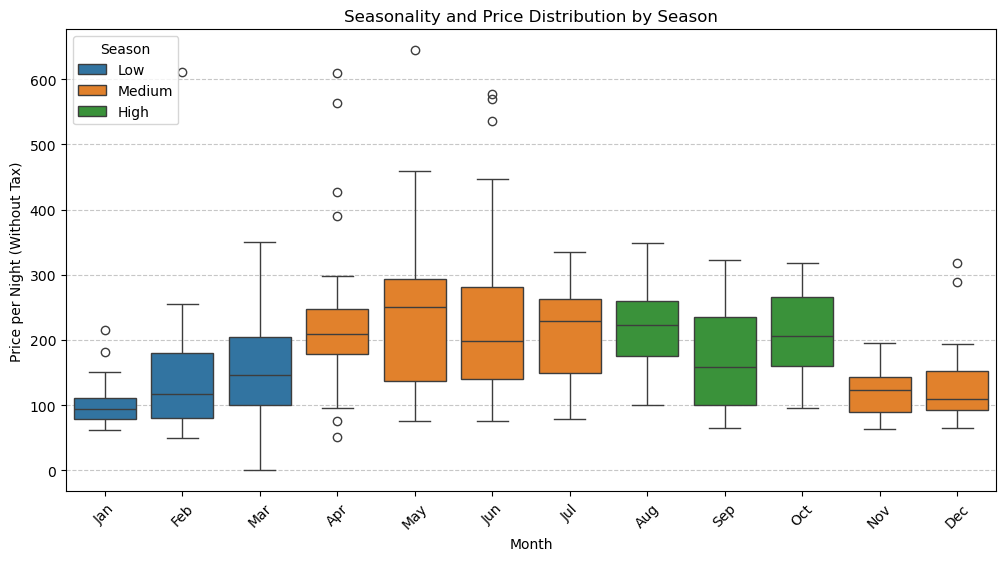

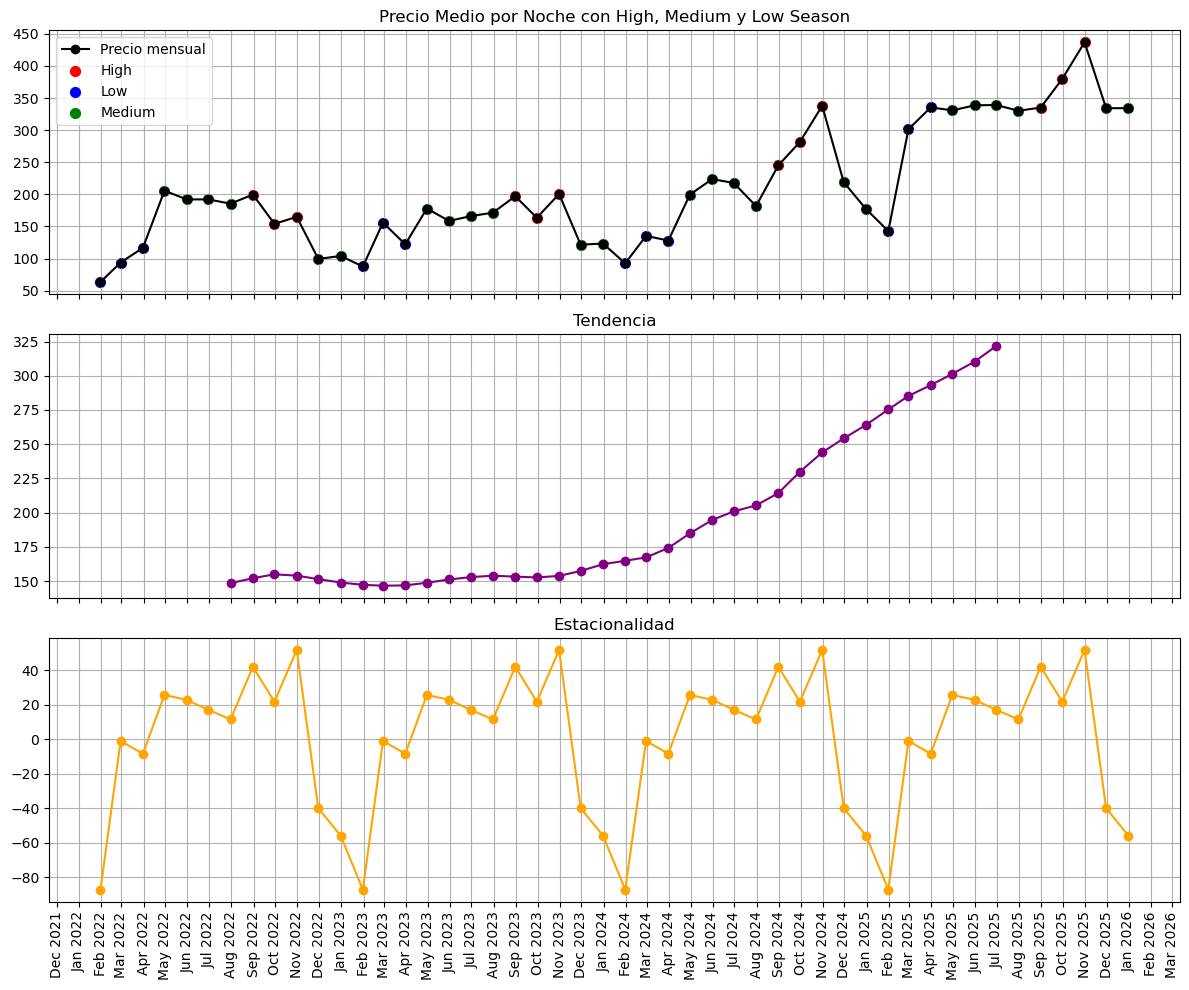

In [134]:
# Seasonality: The month of the year

# Ensure the date columns are in the correct format
pricing_data['Date'] = pd.to_datetime(pricing_data['Date'])

# Filtering the data 
price_data = pricing_data[['Date', 'Price per night without tax']].copy()
price_data = price_data.sort_values(by='Date')
price_data = price_data.set_index('Date')
price_data = price_data['Price per night without tax']

# Average the prices by month
price_data = price_data.resample('ME').mean()

# Analyze the seasonality in the price data
result_stl = seasonal_decompose(price_data, model='additive', period=12)
trend = result_stl.trend
seasonal = result_stl.seasonal

# Classify the months into high, medium, and low seasons based on the average price
# Use the quantiles to classify the months
monthly_avg_price = price_data.groupby(price_data.index.month).mean()

# Define the high, medium, and low seasons based on the quantiles
high_season_months = monthly_avg_price[monthly_avg_price > monthly_avg_price.quantile(0.75)].index
low_season_months = monthly_avg_price[monthly_avg_price < monthly_avg_price.quantile(0.25)].index
medium_season_months = monthly_avg_price[(monthly_avg_price >= monthly_avg_price.quantile(0.25)) & 
                                          (monthly_avg_price <= monthly_avg_price.quantile(0.75))].index

# Dictionary to map the months to the season
season_dict = {}
for month in high_season_months:
    season_dict[month] = 'High'
for month in low_season_months:
    season_dict[month] = 'Low'
for month in medium_season_months:
    season_dict[month] = 'Medium'

# Check the date format
booking_data['Check-in date'] = pd.to_datetime(booking_data['Check-in date'])

# Convert the check-in date to month
booking_data['Check-in Month'] = booking_data['Check-in date'].dt.month

# Map the months to the season
booking_data['Season'] = booking_data['Check-in Month'].map(season_dict)

# Verify the season column
missing_season_count = booking_data['Season'].isna().sum()
print(f"Valores nulos en la columna 'Season': {missing_season_count}")

# Visualize the seasonality and price distribution by season
plt.figure(figsize=(12, 6))
sns.boxplot(x=booking_data['Check-in Month'], y=booking_data['Price per night without tax'], hue=booking_data['Season'])

plt.xlabel('Month')
plt.ylabel('Price per Night (Without Tax)')
plt.title('Seasonality and Price Distribution by Season')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Season", loc="upper left")
plt.show()

# Plot the price data, trend, and seasonality
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Original price data
ax[0].plot(price_data, marker="o", linestyle="-", color="black", label="Precio mensual")

# High season
ax[0].scatter(price_data[price_data.index.month.isin(high_season_months)].index, 
              price_data[price_data.index.month.isin(high_season_months)], 
              color="red", label="High", s=50)

# Low season
ax[0].scatter(price_data[price_data.index.month.isin(low_season_months)].index, 
              price_data[price_data.index.month.isin(low_season_months)], 
              color="blue", label="Low", s=50)

# Medium season
ax[0].scatter(price_data[price_data.index.month.isin(medium_season_months)].index, 
              price_data[price_data.index.month.isin(medium_season_months)], 
              color="green", label="Medium", s=50)

ax[0].set_title("Precio Medio por Noche con High, Medium y Low Season")
ax[0].legend()
ax[0].grid()

# Trend
ax[1].plot(trend, marker="o", linestyle="-", color="purple")
ax[1].set_title("Tendencia")
ax[1].grid()

# Seasonality
ax[2].plot(seasonal, marker="o", linestyle="-", color="orange")
ax[2].set_title("Estacionalidad")
ax[2].grid()

# Labels and formatting
from matplotlib import dates as mdates
ax[2].xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Mostrar cada 1 meses
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # Formato: Ene 2023, Feb 2023, ...

plt.xticks(rotation=90)  # Rotar etiquetas de meses
plt.tight_layout()
plt.show()

# Anotation: The seasonality is clear in the price data, with a period of 12 months, and the trend is increasing over time


Check-in Day
Friday       58
Thursday     42
Wednesday    38
Sunday       37
Monday       35
Tuesday      33
Saturday     21
Name: count, dtype: int64


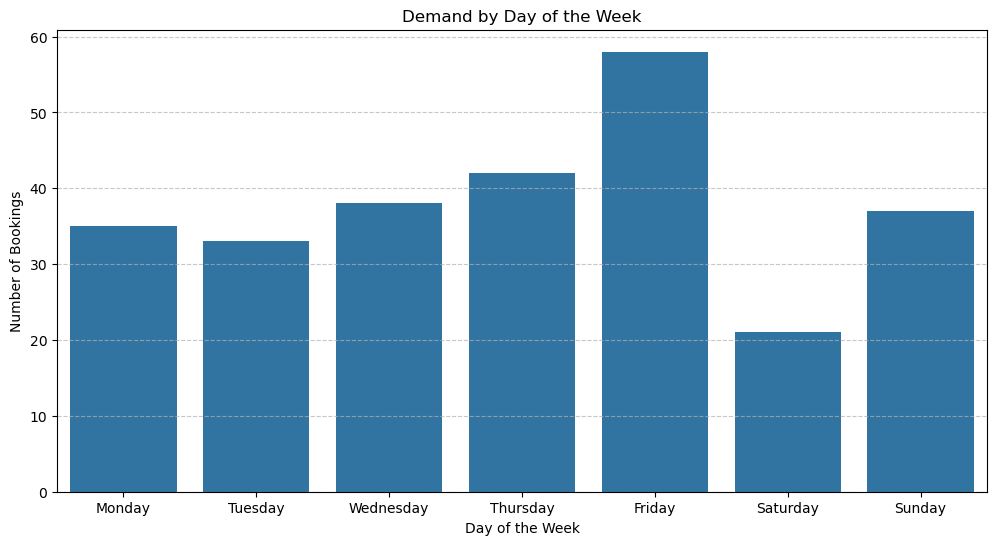

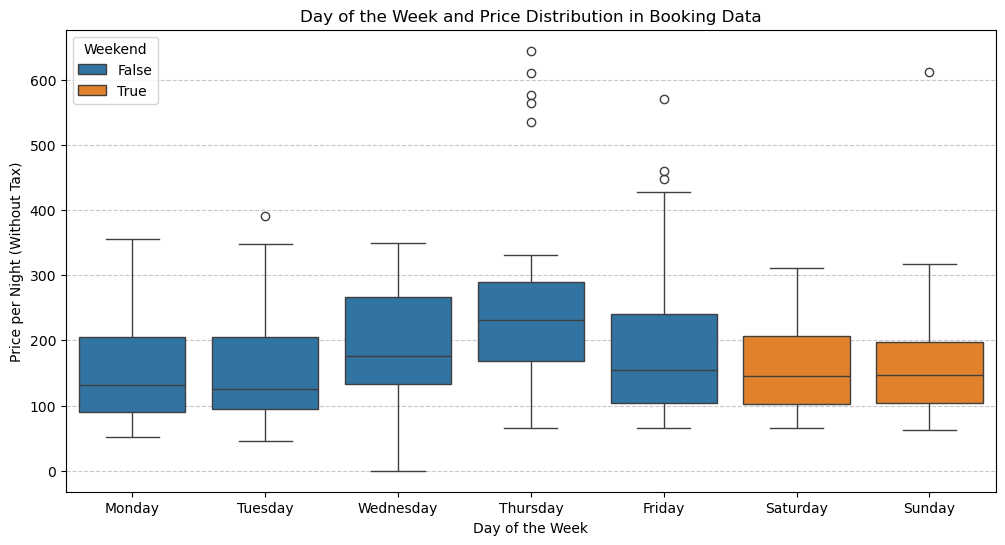

Missing values after resampling:
 Date
2022-05-20   NaN
2022-05-21   NaN
2023-10-23   NaN
2023-10-24   NaN
2024-06-21   NaN
2025-03-02   NaN
2025-03-03   NaN
2025-03-04   NaN
2025-03-05   NaN
2025-03-06   NaN
2025-03-07   NaN
Name: Price per night without tax, dtype: float64


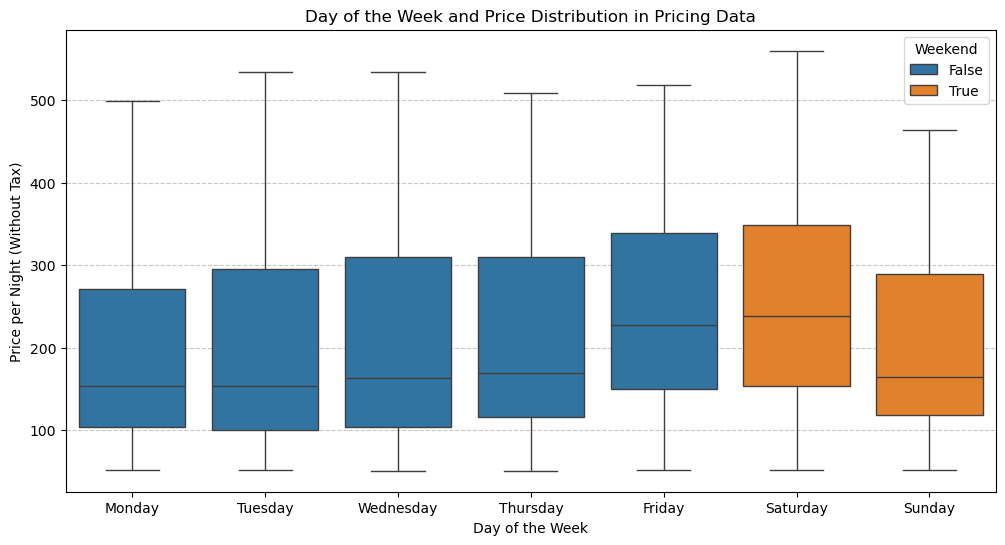

Check-in Day   Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Season                                                                       
High          147.370   202.46     229.41   254.790  172.30    191.36  237.46
Low           119.635    69.21     112.86   165.585  105.00     95.30  169.29
Medium        132.000   147.02     177.04   238.260  212.86    200.40  140.00


/tmp/ipykernel_208/2056619565.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_day_price = booking_data.groupby(['Season', 'Check-in Day'])['Price per night without tax'].median().unstack()


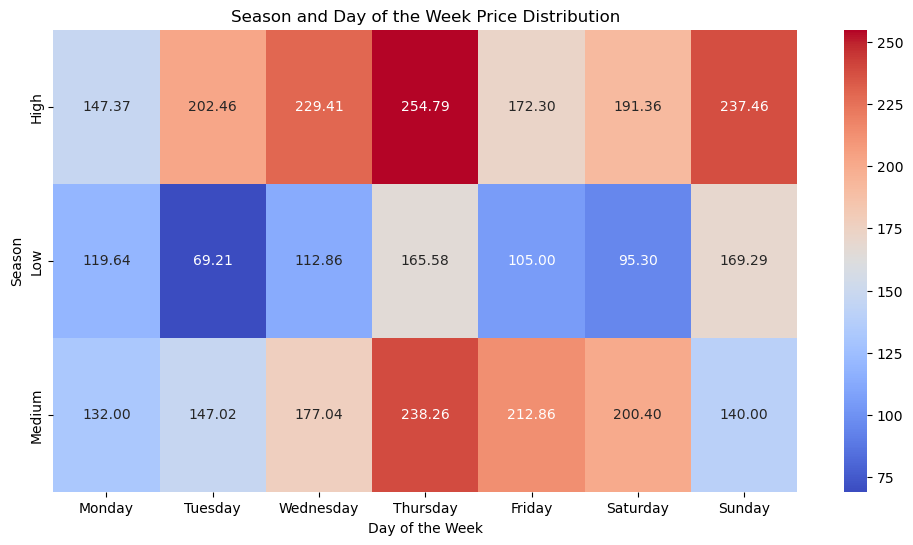

Check-in Day  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Season                                                                      
High               4       11         12         9      13         5       3
Low               10        7          7         8      15         8       9
Medium            21       15         19        25      30         8      25


/tmp/ipykernel_208/2056619565.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_demand = booking_data.groupby(['Season', 'Check-in Day']).size().unstack()


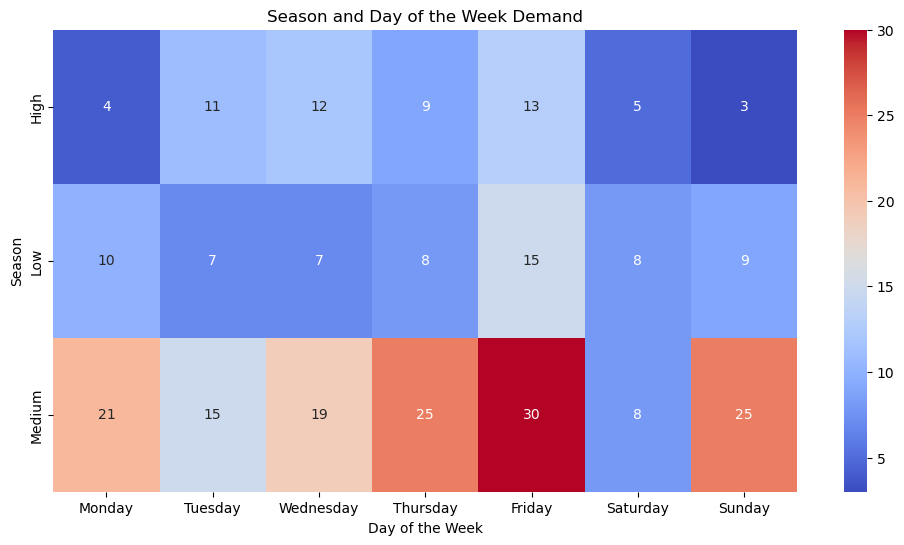

In [140]:
# Day of the week:  
# Review the days on which the booking falls to understand the demand by the day. This helps to understand what days of the week are
# people booking. For example the demand for week ends might be higher than the weekdays even in high season and hence the price per night cannot be
# the same for Monday and Friday.

booking_data['Check-in Day'] = booking_data['Check-in date'].dt.day_name()
demand_by_day = booking_data['Check-in Day'].value_counts()
print(demand_by_day)

# Sort the days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
demand_by_day = demand_by_day.reindex(days)

# Visualize the demand by day of the week
plt.figure(figsize=(12, 6))
sns.barplot(x=demand_by_day.index, y=demand_by_day.values)

plt.xlabel('Day of the Week')
plt.ylabel('Number of Bookings')
plt.title('Demand by Day of the Week')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Sort the days of the week
booking_data['Check-in Day'] = pd.Categorical(booking_data['Check-in Day'], categories=days, ordered=True)
# Define weekends and weekdays
weekends = ['Saturday', 'Sunday']
booking_data['Weekend'] = booking_data['Check-in Day'].isin(weekends)

# Visualize the day of the week and price distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x=booking_data['Check-in Day'], y=booking_data['Price per night without tax'], hue=booking_data['Weekend'])

plt.xlabel('Day of the Week')
plt.ylabel('Price per Night (Without Tax)')
plt.title('Day of the Week and Price Distribution in Booking Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Day of the week analysis with STL in price data
pricing_data['Date'] = pd.to_datetime(pricing_data['Date'])
price_data = pricing_data[['Date', 'Price per night without tax']].copy()
price_data = price_data.sort_values(by='Date')
price_data = price_data.set_index('Date')
price_data = price_data['Price per night without tax']
price_data = price_data.resample('D').mean()

# Check again for any potential missing values after resampling
if price_data.isna().any():
    print("Missing values after resampling:\n", price_data[price_data.isna()])
    # Fill the missing values 
    price_data = price_data.ffill()
    # This I have to reconsider because I'm filling the missing values with the previous value

# Sort the days of the week
pricing_data['Day of the Week'] = pricing_data['Date'].dt.day_name()
pricing_data['Day of the Week'] = pd.Categorical(pricing_data['Day of the Week'], categories=days, ordered=True)
# Define weekends and weekdays
pricing_data['Weekend'] = pricing_data['Day of the Week'].isin(weekends)
# Visualize the weekends and weekdays price distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x=pricing_data['Day of the Week'], y=pricing_data['Price per night without tax'], hue=pricing_data['Weekend'])

plt.xlabel('Day of the Week')
plt.ylabel('Price per Night (Without Tax)')
plt.title('Day of the Week and Price Distribution in Pricing Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Group by season and day of the week
season_day_price = booking_data.groupby(['Season', 'Check-in Day'])['Price per night without tax'].median().unstack()
print(season_day_price)

# Visualize the season and day of the week price distribution
plt.figure(figsize=(12, 6))
sns.heatmap(season_day_price, cmap='coolwarm', annot=True, fmt=".2f")

plt.xlabel('Day of the Week')
plt.ylabel('Season')
plt.title('Season and Day of the Week Price Distribution')
plt.show()

# Group by season and day of the week
seasonal_demand = booking_data.groupby(['Season', 'Check-in Day']).size().unstack()
print(seasonal_demand)

# Visualize the season and day of the week demand
plt.figure(figsize=(12, 6))
sns.heatmap(seasonal_demand, cmap='coolwarm', annot=True, fmt="d")

plt.xlabel('Day of the Week')
plt.ylabel('Season')
plt.title('Season and Day of the Week Demand')
plt.show()


Check-in Month
1     55.000000
2     81.666667
3     83.333333
4     79.166667
5     75.833333
6     80.833333
7     91.666667
8     95.833333
9     71.666667
10    50.833333
11    59.166667
12    63.333333
Name: nights, dtype: float64


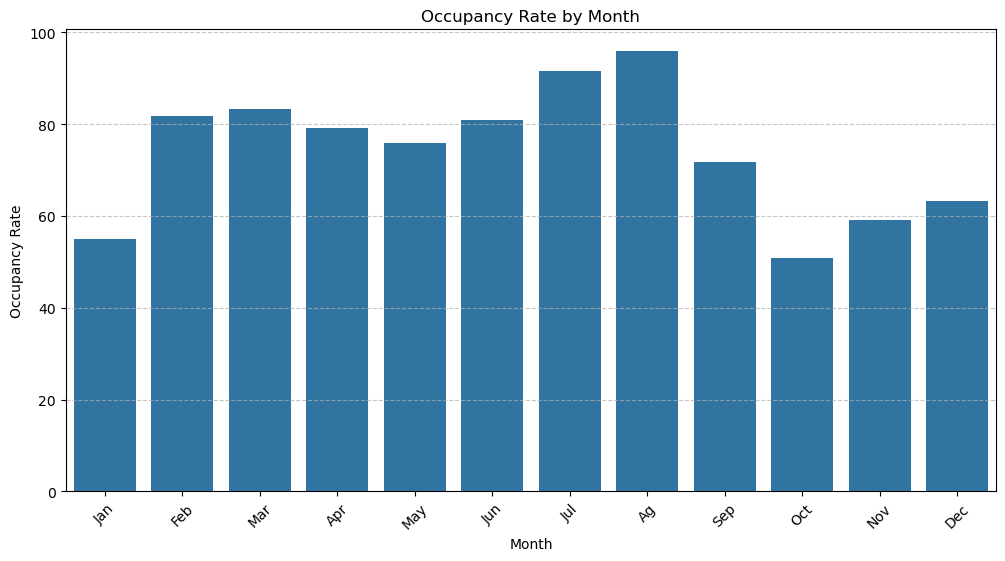

In [141]:
# Occupancy Rate: Calculate the occupancy rate for each month to understand how full the property was over time. As it helps to benchmark it
# against the past performance and market forecast. Example if we are pacing behind in occupancy we could offer a discount on the price to get some quick
# bookings to build the base

# Calculate the occupancy rate for each month
# Assuming that the property has 4 rooms and each room is booked for 30 days in a month
monthly_occupancy = booking_data.groupby('Check-in Month')['nights'].sum() / (30 * 4) * 100
print(monthly_occupancy)

# Visualize the occupancy rate by month
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_occupancy.index, y=monthly_occupancy.values)

plt.xlabel('Month')
plt.ylabel('Occupancy Rate')
plt.title('Occupancy Rate by Month')

plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ag', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Exploratory Data Analysis (EDA)

* Calculate the Mean, Median, standard deviation, Min and max values of
below mentioned numerical features:

    * Occupancy rate
    * Lead time
    * Length of stay

* Visualisation
    * The features they created in the first part of the exercise to spot
    trends.

* Correlation Analysis
    * Perform a correlation analysis between the features and the price per
    night to understand which features are strongly associated or have the
    biggest impact on the price per night.

--- Occupancy Rate ---
count    12.000000
mean     74.027778
std      14.296788
min      50.833333
25%      62.291667
50%      77.500000
75%      82.083333
max      95.833333
Name: nights, dtype: float64

--- Booking Window ---
count    264.000000
mean      11.992424
std       15.582478
min        0.000000
25%        1.000000
50%        4.500000
75%       21.000000
max      112.000000
Name: Booking window, dtype: float64

--- Length of Stay ---
count    264.000000
mean       4.037879
std        3.019343
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       28.000000
Name: nights, dtype: float64



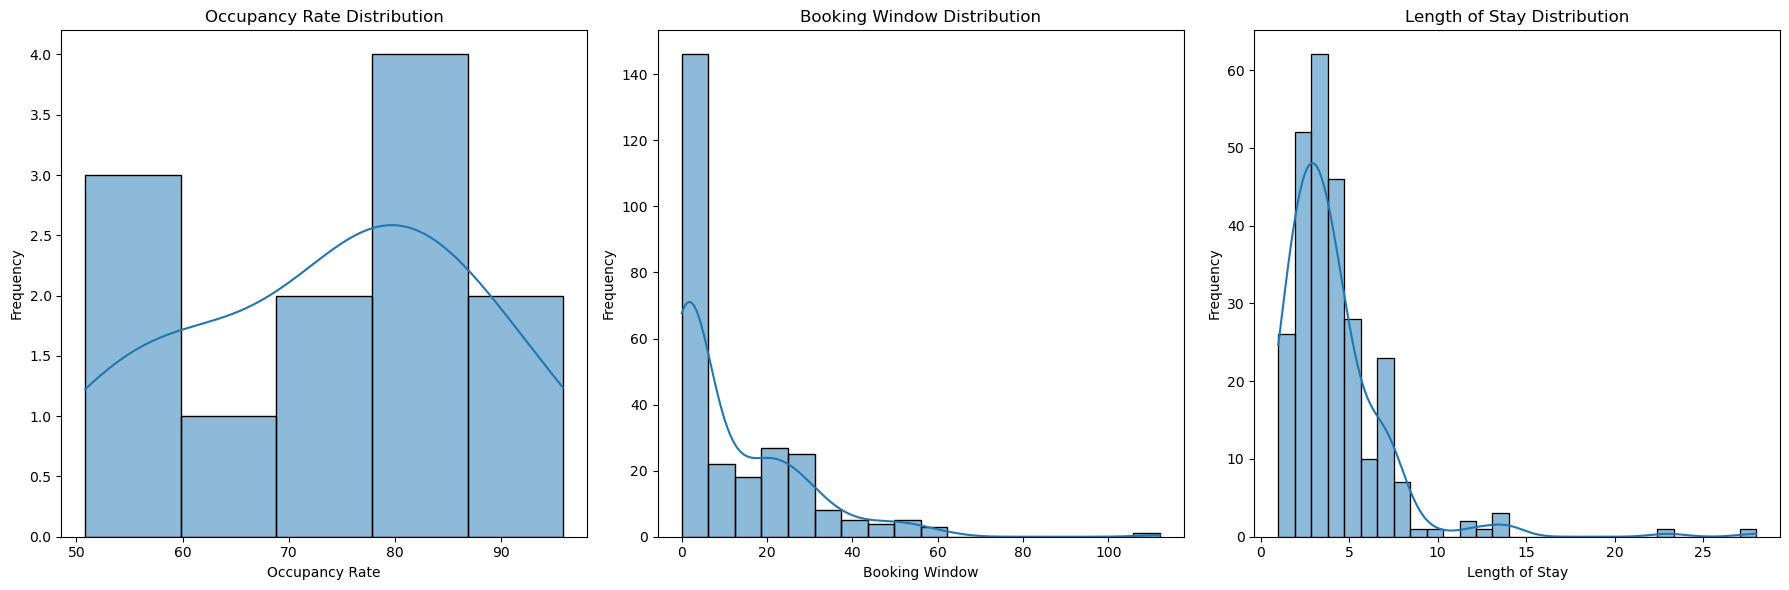

In [142]:
# Explorative Data Analysis

# Calculate the mean, median, standard deviation, min and max values of occupancy rate, lead time, and length of stay
stats = {}

# Occupancy rate
stats['Occupancy Rate'] = monthly_occupancy.describe()

# Booking window
stats['Booking Window'] = booking_data['Booking window'].describe()

# Length of stay
stats['Length of Stay'] = booking_data['nights'].describe()

# Print the statistics
for key, value in stats.items():
    print(f'--- {key} ---\n{value}\n')

# Visualize the distribution of the occupancy rate, booking window, and length of stay
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(monthly_occupancy, kde=True)
plt.xlabel('Occupancy Rate')
plt.ylabel('Frequency')
plt.title('Occupancy Rate Distribution')

plt.subplot(1, 3, 2)
sns.histplot(booking_data['Booking window'], kde=True)
plt.xlabel('Booking Window')
plt.ylabel('Frequency')
plt.title('Booking Window Distribution')

plt.subplot(1, 3, 3)
sns.histplot(booking_data['nights'], kde=True)
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.title('Length of Stay Distribution')

plt.tight_layout()
plt.show()

Most significant correlations with the price per night:
Price per night without tax                                1.000000
Rent without VAT                                           0.655201
Booking total without tax                                  0.649491
Paid                                                       0.649002
Total tax                                                  0.406257
Booking window                                             0.373918
Check-in Day_Thursday                                      0.286709
Adults                                                     0.240027
Website of origin_www.vrbo.com                             0.221748
Portal / Agent_Homeaway.com                                0.221748
Season_Medium                                              0.159076
Website of origin_homes-and-villas.marriott.com            0.092027
Portal / Agent_Homes & Villas by Marriott International    0.092027
Website of origin_www.airbnb.com                           0

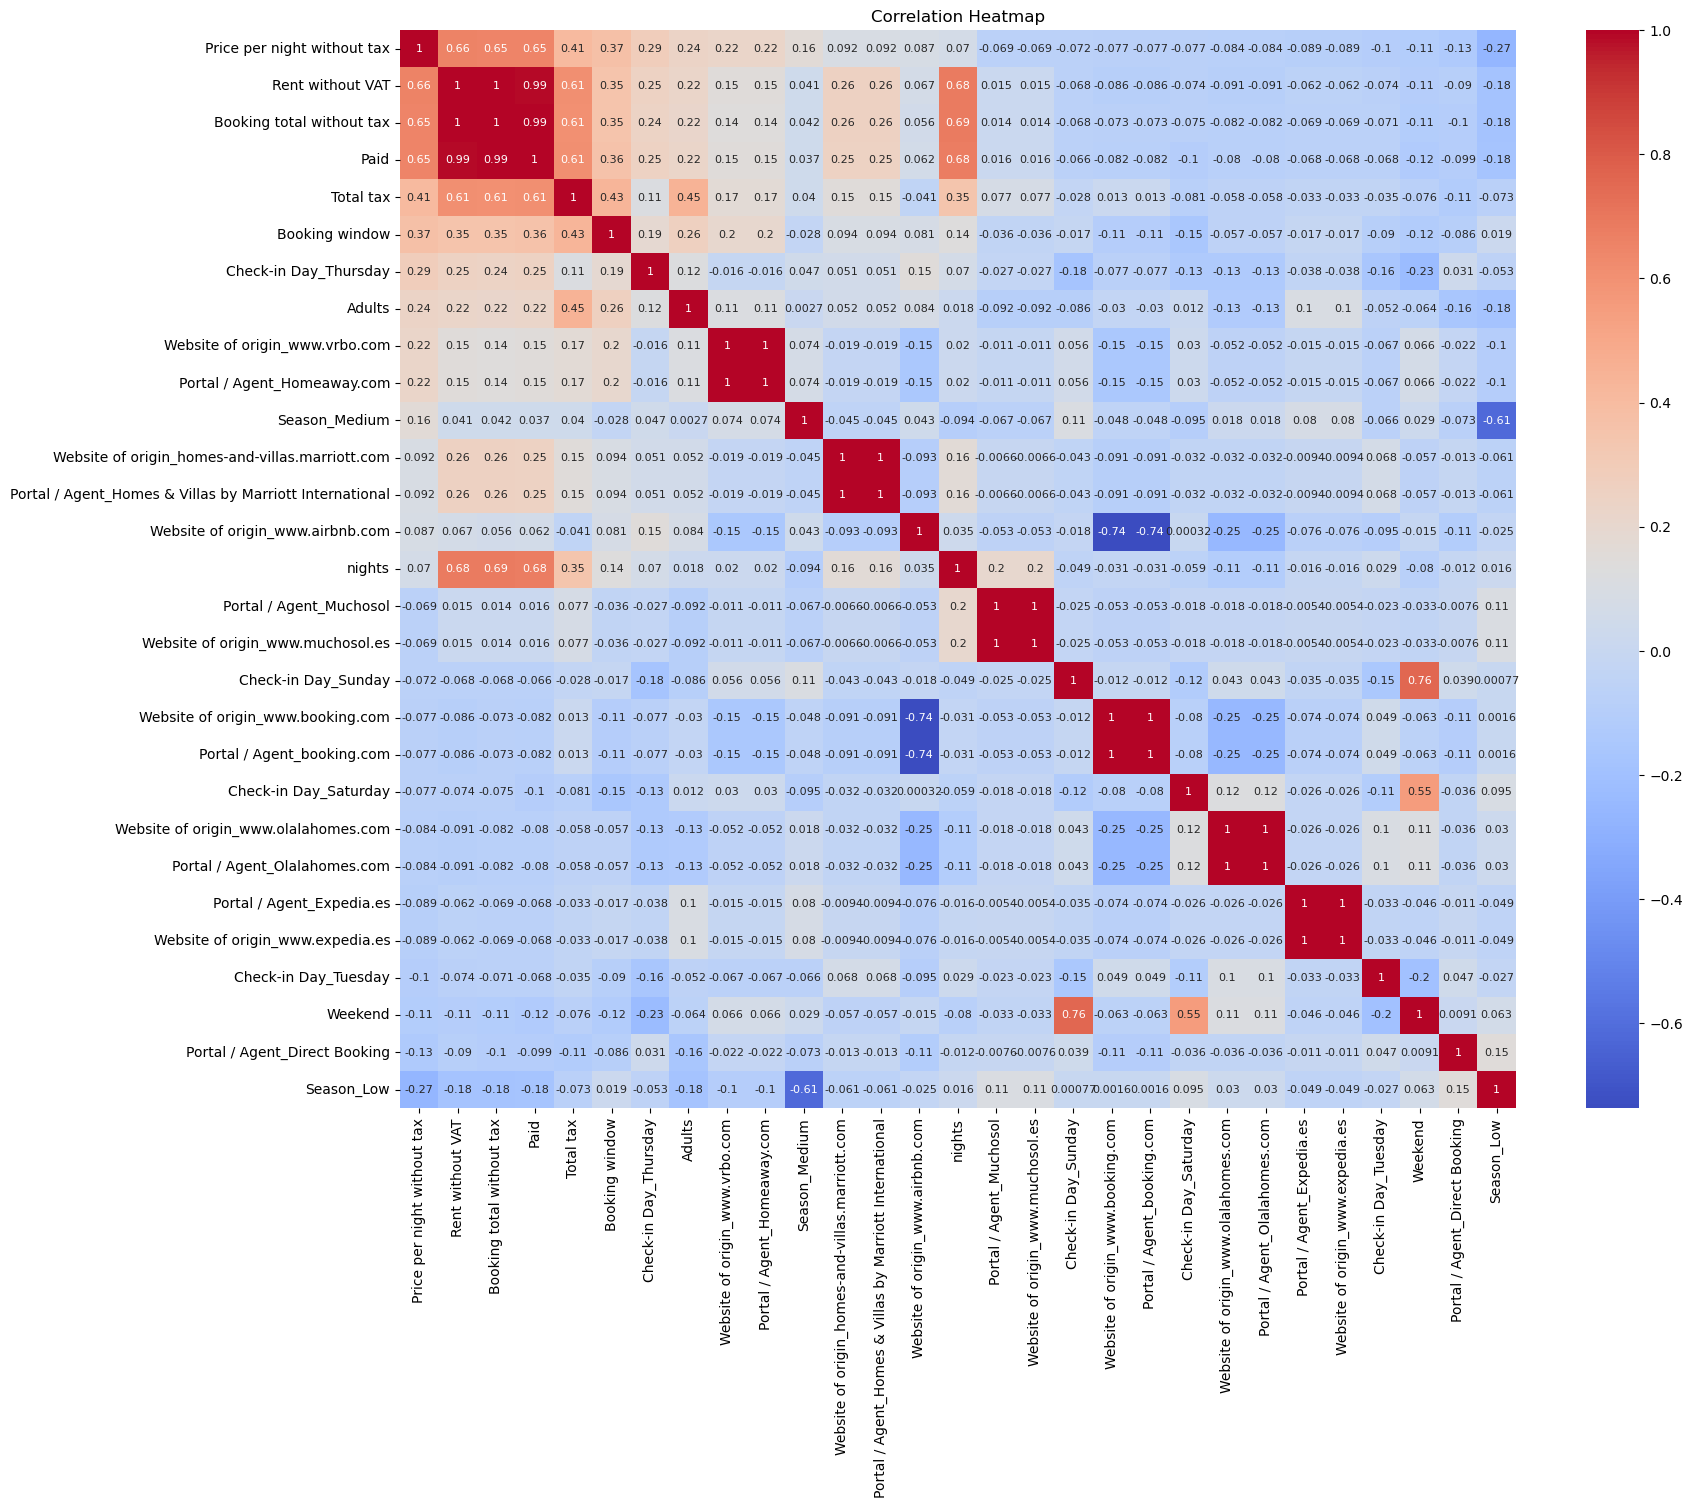

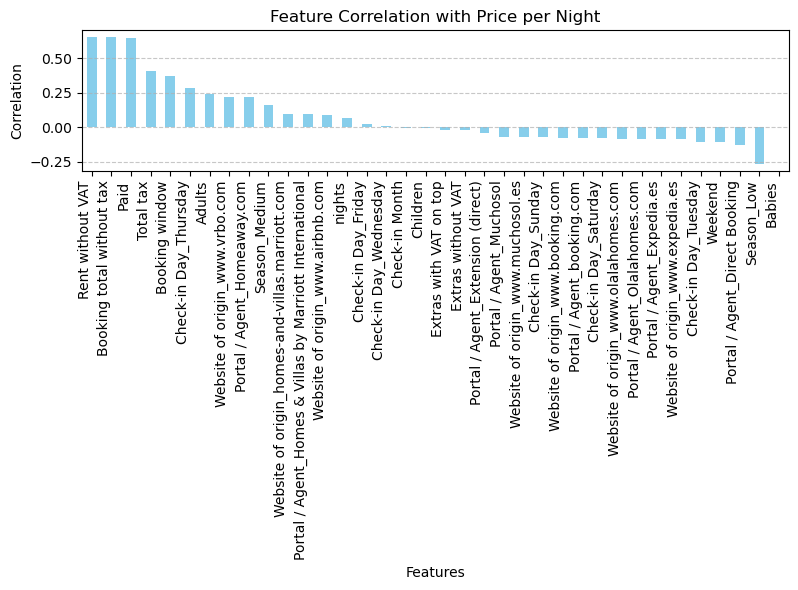

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation Analysis

# Identify noise and outliers in the data
booking_data_clean_corr = booking_data.copy()

# Drop columns that are not relevant
columns_to_drop = [
    'Booking number',  # Identifier
    'Status',  # String column
    'Accommodation name',  # String column
    'Property ID',  # Identifier
    'Building',  # String column
    'City',  # String column
    'Rent with VAT on top',  # Redundant column
    'Booking total with tax',  # Redundant column
    'Check-in date',  # Low relevance
    'Check-out date',  # Low relevance
    'Booking Date'  # Low relevance
]

# Drop the identified columns
booking_data_clean_corr = booking_data_clean_corr.drop(columns=columns_to_drop, errors='ignore')

# Convert categorical data to dummies (if there are categorical columns)
booking_data_clean_corr = pd.get_dummies(booking_data_clean_corr, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = booking_data_clean_corr.corr()

# Filter the correlations with respect to 'Price per night without tax'
price_corr = correlation_matrix['Price per night without tax'].sort_values(ascending=False)

# Keep only features with |corr| > 0.05
relevant_features = price_corr[abs(price_corr) > 0.05].index
booking_data_clean_corr = booking_data_clean_corr[relevant_features]

# Show the most significant correlations
print("Most significant correlations with the price per night:")
print(price_corr[relevant_features])

# Visualize the correlations as a heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix.loc[relevant_features, relevant_features], cmap="coolwarm", annot=True, cbar=True, annot_kws={'size': 8})
plt.title('Correlation Heatmap')
plt.show()

# If you prefer to see only the correlations with the price
plt.figure(figsize=(8, 6))
price_corr.drop('Price per night without tax').plot(kind='bar', color='skyblue')
plt.title('Feature Correlation with Price per Night')
plt.ylabel('Correlation')
plt.xlabel('Features')
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Interpretation:
# Key Findings from the Correlation Analysis

# Variables with Strong Positive Correlation:
# Rent without VAT (0.655): There is a high correlation between rent without VAT and the price per night, which is expected since rent typically reflects the base cost of the accommodation that is passed onto the customer.
# Booking total without tax (0.649): The total cost of the booking without taxes also has a strong correlation with the price per night, as it reflects the overall cost that the customer pays for the stay, excluding taxes. Also expected.
# Paid (0.649): The amount paid for the booking is strongly correlated with the price per night, suggesting that higher-value bookings tend to have higher per-night prices. Also expected.
# Total tax (0.406): Taxes also show a moderate correlation with the price per night, which is typical as the price often includes taxes or additional fees.
# Booking window (0.374): The booking window (the time between booking and check-in) has a moderate correlation with price per night. This could indicate that last-minute bookings tend to be more expensive.
# Check-in Day_Thursday (0.287): Bookings with a check-in on Thursday show a positive correlation with price, possibly due to increased demand for mid-week stays.
# Adults (0.24): A higher number of adults in a booking appears to be positively correlated with the price per night, suggesting that larger bookings tend to have higher prices.
# Website of origin_www.vrbo.com (0.222) and Portal / Agent_Homeaway.com (0.222): Both VRBO and Homeaway show a positive correlation with higher prices, implying that customers booking through these platforms may be willing to pay more.

# Variables with Negative or Low Correlation:
# Season_Low (-0.269): Bookings during the low season are negatively correlated with the price per night, which aligns with the expectation that prices tend to be lower during off-peak seasons.
# Check-in Day_Sunday (-0.072): Bookings with a Sunday check-in show a small negative correlation with the price, possibly indicating lower demand or discounts for Sunday check-ins.
# Website of origin_www.booking.com (-0.077): Bookings from Booking.com show a slight negative correlation with price, suggesting that prices may be slightly lower on this platform.
# Portal / Agent_booking.com (-0.077): Similar to the website origin, bookings made through agents on Booking.com also tend to have lower prices.
# Weekend (-0.111): Weekend bookings show a small negative correlation with the price per night, which could indicate lower prices or discounts for weekend stays.

# Recommendations:
# Focus on Key Drivers: Variables like Booking window is an indicator that should be taken into account when setting prices.
# Consider Seasonal Pricing: The negative correlation with low season and the weekend suggests that pricing strategies should vary based on the season and the day of the week to optimize revenue.
# Optimize Platform Pricing: The differences in prices across platforms like Booking.com, VRBO, and Homeaway could be leveraged for targeted pricing strategies, as some platforms attract customers willing to pay more.

Feature Importances:
Rent without VAT                                           0.442382
nights                                                     0.271415
Paid                                                       0.149233
Booking total without tax                                  0.075156
Booking window                                             0.018084
Total tax                                                  0.011023
Adults                                                     0.010932
Check-in Day_Thursday                                      0.005680
Season_Low                                                 0.002821
Portal / Agent_Homeaway.com                                0.002517
Website of origin_www.airbnb.com                           0.002060
Check-in Day_Tuesday                                       0.001647
Season_Medium                                              0.001393
Website of origin_www.vrbo.com                             0.001047
Weekend                    

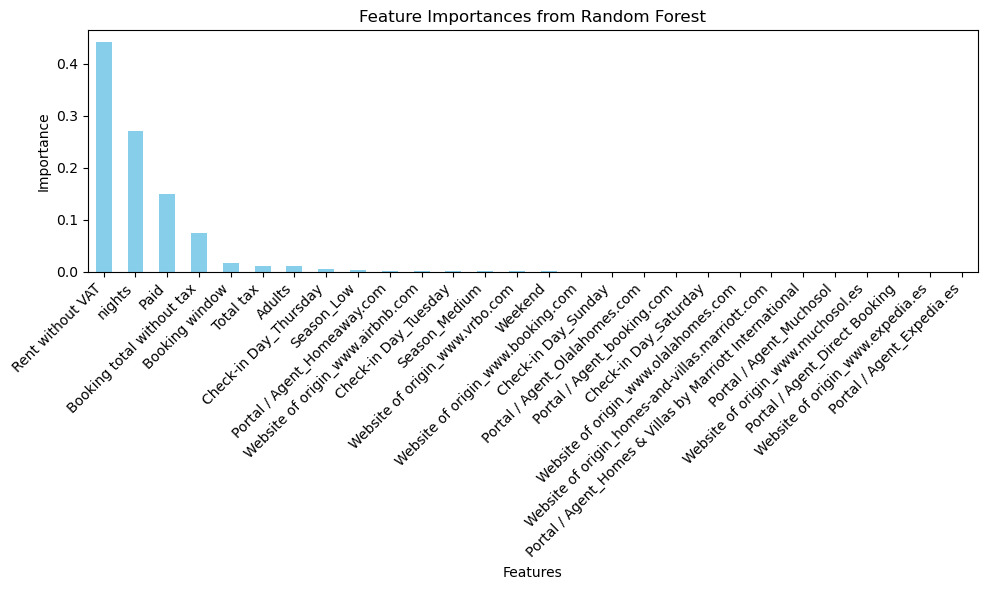

In [150]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(booking_data_clean_corr.drop(columns=['Price per night without tax']), booking_data_clean_corr['Price per night without tax'])

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=booking_data_clean_corr.drop(columns=['Price per night without tax']).columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("Feature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [151]:
# Save all the cleaned data in nwes csv files

# Save the cleaned data
pricing_data.to_csv(pwd + '/data/pricing_data_cleaned.csv', index=False)
booking_data.to_csv(pwd + '/data/booking_data_cleaned.csv', index=False)
competitor_data.to_csv(pwd + '/data/competitor_data_cleaned.csv', index=False)